<a href="https://colab.research.google.com/github/AybarsCebi/Crowd-Counting-with-Image-Processing/blob/main/AMRNet50%20with%20DeepSupervision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[bağlantı metni](https://)from google.colab import drive
drive.mount('/content/drive')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class CBAMModule(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.channel_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.channel_max_pool = nn.AdaptiveMaxPool2d(1)
        self.shared_mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
        )
        self.sigmoid_channel = nn.Sigmoid()
        self.spatial_conv = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=3, padding=1, bias=False),
        )
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        avg = self.channel_avg_pool(x).view(b, c)
        mx  = self.channel_max_pool(x).view(b, c)
        avg_out = self.shared_mlp(avg).view(b, c, 1, 1)
        mx_out  = self.shared_mlp(mx ).view(b, c, 1, 1)
        x = x * self.sigmoid_channel(avg_out + mx_out)

        avg_sp = x.mean(dim=1, keepdim=True)
        mx_sp, _ = x.max(dim=1, keepdim=True)
        x = x * self.sigmoid_spatial(self.spatial_conv(torch.cat([avg_sp, mx_sp], dim=1)))
        return x

class AMRNet_ResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        # Bottleneck blok kullanan ResNet‑50, layer3’te dilation uygulanmış
        resnet = models.resnet50(
            pretrained=True,
            replace_stride_with_dilation=[False, False, True]
        )

        # İlk aşama
        self.initial = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool
        )
        # Scale katmanları
        self.scale1 = resnet.layer1  # 256 kanallı
        self.scale2 = resnet.layer2  # 512 kanallı, ↓8
        self.scale3 = resnet.layer3  # 1024 kanallı, ↓16

        # Attention modüllerini kanal sayılarına göre ayarlayın
        self.att1 = CBAMModule(256)
        self.att2 = CBAMModule(512)
        self.att3 = CBAMModule(1024)

        # Ara supervision head’leri
        self.head1 = nn.Conv2d(256, 1, kernel_size=1)
        self.head2 = nn.Conv2d(512, 1, kernel_size=1)
        self.head3 = nn.Conv2d(1024,1, kernel_size=1)

        # Fuse ve çıkış
        self.fusion_conv = nn.Conv2d(256 + 512 + 1024, 256, kernel_size=1)
        self.density_map = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64,  kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64,   1,   kernel_size=1),
        )

    def forward(self, x):
        x = self.initial(x)
        x1 = self.att1(self.scale1(x))
        x2 = self.att2(self.scale2(x1))
        x3 = self.att3(self.scale3(x2))

        # Ara supervision haritaları
        d1 = F.interpolate(self.head1(x1), size=x1.shape[2:], mode='bilinear', align_corners=False)
        d2 = F.interpolate(self.head2(x2), size=x1.shape[2:], mode='bilinear', align_corners=False)
        d3 = F.interpolate(self.head3(x3), size=x1.shape[2:], mode='bilinear', align_corners=False)

        # Feature map’leri birleştir
        x2u = F.interpolate(x2, size=x1.shape[2:], mode='bilinear', align_corners=False)
        x3u = F.interpolate(x3, size=x1.shape[2:], mode='bilinear', align_corners=False)
        fused = torch.cat([x1, x2u, x3u], dim=1)
        fused = self.fusion_conv(fused)

        final = self.density_map(fused)
        if self.training:
            return final, (d1, d2, d3)
        return final




In [ ]:
import scipy.io
import numpy as np
import cv2
import os

def generate_density_map(img_shape, points, sigma=15):
    """512x512 boyutunda yoğunluk haritası üretir."""
    density_map = np.zeros((512, 512), dtype=np.float32)

    for point in points:
        x, y = min(int(point[0]), 511), min(int(point[1]), 511)
        density_map[y, x] = 1  # Noktayı yerleştir

    density_map = cv2.GaussianBlur(density_map, (0, 0), sigma)
    if density_map.sum() > 0:
        density_map *= (len(points) / density_map.sum())  # Toplam kişi sayısını koru

    return density_map

# Veri seti yolları
data_path = "/content/drive/MyDrive/dataset/train_data/images"
gt_path = "/content/drive/MyDrive/dataset/train_data/ground_truth"
output_dir = "/content/drive/MyDrive/dataset/train_data/density_maps"

os.makedirs(output_dir, exist_ok=True)

for img_file in os.listdir(data_path):
    if not img_file.startswith("IMG_") or not img_file.endswith(".jpg"):
        continue

    img_path = os.path.join(data_path, img_file)

    # Resim ismini ground truth dosyasına uygun hale getir
    img_number = img_file.replace("IMG_", "").replace(".jpg", "")
    gt_path_mat = os.path.join(gt_path, f"GT_IMG_{img_number}.mat")

    if not os.path.exists(gt_path_mat):
        print(f"Uyarı: {gt_path_mat} bulunamadı, atlanıyor.")
        continue

    # Ground truth noktalarını yükle
    mat = scipy.io.loadmat(gt_path_mat)
    points = mat["image_info"][0, 0][0, 0][0]  # (x, y) koordinatları

    # Görüntüyü oku ve 512x512 boyutuna getir
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    img_resized = cv2.resize(img, (512, 512))

    # Koordinatları yeniden ölçeklendir
    points_rescaled = points * [512 / w, 512 / h]

    # Yoğunluk haritası oluştur
    density_map = generate_density_map(img_resized.shape, points_rescaled)

    # .npy olarak kaydet
    npy_path = os.path.join(output_dir, img_file.replace("IMG_", "IMG_").replace(".jpg", ".npy"))
    np.save(npy_path, density_map)


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Örnek boyutlar; veri setinizin özelliklerine göre ayarlanabilir:
IMG_HEIGHT = 512
IMG_WIDTH = 512

# Train seti için augmentasyonlar
train_transform = A.Compose([
    A.RandomCrop(width=IMG_WIDTH, height=IMG_HEIGHT, p=1.0),            # Rastgele kırpma
    A.HorizontalFlip(p=0.5),                                              # %50 olasılıkla yatay çevirme
    A.RandomRotate90(p=0.5),                                              # %50 olasılıkla 90 derece rastgele döndürme
    A.RandomScale(scale_limit=0.1, p=0.5),                                  # Küçük ölçeklendirme varyasyonları
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),  # Renk varyasyonları
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),                              # Normalize (örneğin ImageNet değerleri)
    ToTensorV2(),                                                         # Tensor formatına çevirme
], additional_targets={'density_map': 'image'})

# Validation seti için augmentasyonlar (daha deterministik)
val_transform = A.Compose([
    A.CenterCrop(width=IMG_WIDTH, height=IMG_HEIGHT, p=1.0),              # Center crop
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], additional_targets={'density_map': 'image'})




In [4]:
class CrowdDataset(Dataset):
    def __init__(self, image_dir, density_dir, transform=None):
        self.image_dir = image_dir
        self.density_dir = density_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        density_path = os.path.join(self.density_dir, self.image_files[idx].replace(".jpg", ".npy"))

        # Görüntüyü oku ve normalize et
        image = cv2.imread(img_path)
        image = cv2.resize(image, (512, 512))
        image = image.astype(np.float32) / 255.0  # Normalize et
        image = np.transpose(image, (2, 0, 1))  # PyTorch için (C, H, W) hale getir

        # Yoğunluk haritasını oku ve normalize et
        density_map = np.load(density_path).astype(np.float32)
        density_map = np.expand_dims(density_map, axis=0)  # (1, H, W) formatına getir

        return torch.tensor(image), torch.tensor(density_map)

# Dataset yolları
train_image_dir = "/content/drive/MyDrive/dataset/train_data/images"
train_density_dir = "/content/drive/MyDrive/dataset/train_data/density_maps"

val_imgage_dir = "/content/drive/MyDrive/dataset/validation_data/images"
val_density_dir = "/content/drive/MyDrive/dataset/validation_data/density_maps"


test_image_dir = "/content/drive/MyDrive/dataset/test_data/images"
test_density_dir = "/content/drive/MyDrive/dataset/test_data/density_maps"

# DataLoader oluştur
train_dataset = CrowdDataset(train_image_dir, train_density_dir)
test_dataset = CrowdDataset(test_image_dir, test_density_dir)
val_dataset = CrowdDataset(val_imgage_dir, val_density_dir)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [ ]:
# train_loader'dan bir batch alalım
images, densities = next(iter(train_loader))

print("Images shape:", images.shape)
print("Densities shape:", densities.shape)
print(len(train_loader))  # 0 çıkıyorsa veri gelmiyor!

images, densities = next(iter(train_loader))
print(images.shape, densities.shape)


Images shape: torch.Size([8, 3, 512, 512])
Densities shape: torch.Size([8, 1, 512, 512])
13
torch.Size([8, 3, 512, 512]) torch.Size([8, 1, 512, 512])


In [ ]:
import os

def rename_processed_images(folder_path):
    """
    Belirtilen klasördeki tüm 'processed_IMG_x.jpg' dosyalarını 'IMG_x.jpg' formatına çevirir.

    Args:
        folder_path (str): Resimlerin bulunduğu klasörün yolu.
    """
    for filename in os.listdir(folder_path):
        if filename.startswith("processed_IMG_") and filename.endswith(".jpg"):
            new_name = filename.replace("processed_IMG_", "IMG_")
            old_path = os.path.join(folder_path, filename)
            new_path = os.path.join(folder_path, new_name)
            os.rename(old_path, new_path)
            print(f"Yeniden adlandırıldı: {filename} → {new_name}")

rename_processed_images("/content/drive/MyDrive/dataset/train_data/images")

In [27]:
'''import torch.nn.functional as F

# Laplacian Loss
def laplacian_loss(pred, target):
    laplace_kernel = torch.tensor([[0, 1, 0],
                                   [1, -4, 1],
                                   [0, 1, 0]], dtype=torch.float32, device=pred.device).unsqueeze(0).unsqueeze(0)
    pred_lap = F.conv2d(pred, laplace_kernel, padding=1)
    target_lap = F.conv2d(target, laplace_kernel, padding=1)
    return F.l1_loss(pred_lap, target_lap)

def count_loss(pred, target):
    pred = pred.clamp(min=0)  # Negatif değerleri önler, ReLu sonrası başka işlem yapılsa bile
    target = target.clamp(min=0)
    pred_count = pred.sum(dim=[1, 2, 3])
    target_count = target.sum(dim=[1, 2, 3])
    return F.l1_loss(pred_count, target_count)

# Total Loss (MSE + CountLoss)
def total_loss(pred, target):
    pred = pred.clamp(min=0) #Negatif deperleri önler, ReLu sonrası başka işlem yapılsa bile
    target = target.clamp(min=0)
    mse = F.mse_loss(pred, target)
    count = count_loss(pred, target)
    weight = torch.log(target.sum(dim=[1, 2, 3]) + 10) / 100  # yoğunluk arttıkça ağırlık artar
    weighted_count = (weight * (pred.sum(dim=[1, 2, 3]) - target.sum(dim=[1, 2, 3])).abs()).mean()
    return mse + 0.4 * weighted_count
    # yüksek yoğunluklu örneklerde sayım hatasına daha fazla ceza verir.'''

'''

import torch
import torch.nn.functional as F

def combined_loss(pred_density, gt_density, alpha=0.01):
    """
    Kombine loss fonksiyonu:
    - pred_density: Modelin tahmin ettiği yoğunluk haritası (tensor)
    - gt_density: Gerçek (ground truth) yoğunluk haritası (tensor)
    - alpha: Global (toplam) sayıya ilişkin loss'un ağırlık katsayısı.

    Bu fonksiyon iki bileşenden oluşur:
    1. Piksel bazlı MSE loss: Her pikseldeki hata kare farkı.
    2. Toplam sayı (count) loss: Tahmin edilen toplam kişi sayısı ile gerçeğin L1 farkı.
    """
    # Piksel bazında ortalama kare hatayı hesapla
    pixel_loss = F.mse_loss(pred_density, gt_density)

    # Toplam kişi sayısı farkı, L1 loss olarak hesaplanıyor
    count_loss = torch.abs(pred_density.sum() - gt_density.sum())

    total_loss = pixel_loss + alpha * count_loss
    return total_loss

'''



import torch
import torch.nn.functional as F

def enhanced_loss(pred, gt, alpha=0.001, beta=0.1):
    """
    1) Piksel bazlı Smooth L1 (huber) loss:
       Outlier'lara daha dayanıklı, MSE'den keskin olmayan bir ölçüm.
    2) Count loss (L1) : Toplam kişi sayısını eşitlemek için.
    3) Gradient Loss: Haritanın yerel kenar/detay tutarlılığını korumak için.
    """
    # 1. Smooth L1 loss yerine (MSE yerine) kullanıyoruz
    pixel_loss = F.smooth_l1_loss(pred, gt)

    # 2. Toplam count farkı
    count_loss = F.l1_loss(pred.sum(), gt.sum())

    # 3. Gradient loss (sobel benzeri) – sharper transitions
    def gradients(x):
        gx = x[:, :, 1:, :] - x[:, :, :-1, :]
        gy = x[:, :, :, 1:] - x[:, :, :, :-1]
        return gx, gy

    pgx, pgy = gradients(pred)
    ggx, ggy = gradients(gt)
    grad_loss = F.l1_loss(pgx, ggx) + F.l1_loss(pgy, ggy)

    return pixel_loss + alpha * count_loss + beta * grad_loss


In [51]:
train_losses = []
val_losses = []
val_maes = []
val_mses = []

def train_model(model, train_loader, val_loader, optimizer, device, epochs=80, patience=10, aux_weight=0.2):
    best_val_loss = float('inf')
    patience_counter = 0
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for images, densities in train_loader:
            images    = images.to(device)
            densities = densities.to(device)

            optimizer.zero_grad()

            outputs = model(images)

            if isinstance(outputs, tuple):
                final, (d1, d2, d3) = outputs
            else:
                final = outputs
                d1 = d2 = d3 = None

            if final.shape[-2:] != densities.shape[-2:]:
                final = F.interpolate(final, size=densities.shape[-2:], mode='bilinear', align_corners=False)

            loss_main = criterion(final, densities)

            loss_aux = 0
            if d1 is not None:
                for d in (d1, d2, d3):
                    d = F.interpolate(d, size=densities.shape[-2:], mode='bilinear', align_corners=False)
                    loss_aux += criterion(d, densities)

            total_loss = loss_main + aux_weight * loss_aux
            total_loss.backward()
            optimizer.step()
            train_loss += total_loss.item()

        # Validation
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0

        with torch.no_grad():
            for images, densities in val_loader:
                images    = images.to(device)
                densities = densities.to(device)

                outputs = model(images)
                if isinstance(outputs, tuple):
                    outputs, _ = outputs

                if outputs.shape[-2:] != densities.shape[-2:]:
                    outputs = F.interpolate(outputs, size=densities.shape[-2:], mode='bilinear', align_corners=False)

                loss = criterion(outputs, densities)
                val_loss += loss.item()

                pred_counts = outputs.sum(dim=[1, 2, 3])
                true_counts = densities.sum(dim=[1, 2, 3])
                val_mae += torch.abs(pred_counts - true_counts).sum().item()
                val_mse += ((pred_counts - true_counts) ** 2).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss   = val_loss   / len(val_loader)
        avg_val_mae    = val_mae    / len(val_loader.dataset)
        avg_val_mse    = val_mse    / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val MAE: {avg_val_mae:.2f} | "
              f"Val MSE: {avg_val_mse:.2f}")

        if avg_val_loss <= best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_maes.append(avg_val_mae)
        val_mses.append(avg_val_mse)

    return train_losses, val_losses, val_maes, val_mses


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AMRNet_ResNet50().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

train_model(model, train_loader, val_loader, optimizer, device, epochs=80, patience=10, aux_weight=0.2)



Epoch 1/80 | Train Loss: 0.0026 | Val Loss: 0.0016 | Val MAE: 10216.60 | Val MSE: 104907710.22
Epoch 2/80 | Train Loss: 0.0014 | Val Loss: 0.0006 | Val MAE: 6200.15 | Val MSE: 38934370.67
Epoch 3/80 | Train Loss: 0.0005 | Val Loss: 0.0001 | Val MAE: 1608.71 | Val MSE: 2961568.72
Epoch 4/80 | Train Loss: 0.0003 | Val Loss: 0.0000 | Val MAE: 959.40 | Val MSE: 1308162.35
Epoch 5/80 | Train Loss: 0.0002 | Val Loss: 0.0000 | Val MAE: 419.64 | Val MSE: 531548.86
Epoch 6/80 | Train Loss: 0.0002 | Val Loss: 0.0000 | Val MAE: 602.75 | Val MSE: 456421.20
Epoch 7/80 | Train Loss: 0.0002 | Val Loss: 0.0000 | Val MAE: 485.34 | Val MSE: 415559.15
Epoch 8/80 | Train Loss: 0.0002 | Val Loss: 0.0000 | Val MAE: 409.37 | Val MSE: 436200.42
Epoch 9/80 | Train Loss: 0.0002 | Val Loss: 0.0000 | Val MAE: 438.88 | Val MSE: 420956.44
Epoch 10/80 | Train Loss: 0.0002 | Val Loss: 0.0000 | Val MAE: 430.83 | Val MSE: 417071.34
Epoch 11/80 | Train Loss: 0.0001 | Val Loss: 0.0000 | Val MAE: 436.69 | Val MSE: 418604.

([0.00258577258612674,
  0.001386780166425384,
  0.0005427573476201639,
  0.0002762305398041812,
  0.0002446659827210869,
  0.00020814380415966018,
  0.000187909128166771,
  0.00017253683192673355,
  0.0001628348478474296,
  0.0001582659029876455,
  0.00014952392330787217,
  0.000145752298032256,
  0.00013949196559574024,
  0.00013778407726651774,
  0.00013460068294079974,
  0.0001309694136860064,
  0.00013106988570563353,
  0.00012559522964203588,
  0.00012506101176348658,
  0.00012379513310196882,
  0.00012034791423222766,
  0.0001174833772753258,
  0.00015309263136049805,
  0.00011430528824208662,
  0.00011288063279397857,
  0.00011071968429650251,
  0.00011298647167187973,
  0.0001134918750792097,
  0.00010802275014262144,
  0.0001080319981645936,
  0.00010483706556932212,
  0.00010533554478360411,
  0.00010354186815675348,
  0.00010225656604654013,
  0.0001011356863063366,
  0.00010080053638935518,
  9.890831279335544e-05,
  9.783266516303859e-05,
  9.642385087387923e-05,
  9.7019

In [ ]:
train_losses = []
val_losses = []
val_maes = []
val_mses = []

def train_model(model, train_loader, val_loader, optimizer, device, epochs=5, patience=3):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for images, densities in train_loader:
            images    = images.to(device)
            densities = densities.to(device)

            optimizer.zero_grad()

            # model(images) bir tuple döndürüyor: (final_density_map, (d1,d2,d3))
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs, _ = outputs   # sadece final yoğunluk haritasını al

            # Boyut uyuşmazlığı varsa upsample
            if outputs.shape[-2:] != densities.shape[-2:]:
                outputs = F.interpolate(
                    outputs, size=densities.shape[-2:],
                    mode='bilinear', align_corners=False
                )

            #loss = combined_loss(outputs, densities, alpha=0.01)
            loss = criterion(outputs, densities)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()


        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0

        with torch.no_grad():
            for images, densities in val_loader:
                images    = images.to(device)
                densities = densities.to(device)

                outputs = model(images)
                if isinstance(outputs, tuple):
                    outputs, _ = outputs

                if outputs.shape[-2:] != densities.shape[-2:]:
                    outputs = F.interpolate(
                        outputs, size=densities.shape[-2:],
                        mode='bilinear', align_corners=False
                    )

                #loss = combined_loss(outputs, densities, alpha=0.01)
                loss = criterion(outputs, densities)
                val_loss += loss.item()

                pred_counts = outputs.sum(dim=[1, 2, 3])
                true_counts = densities.sum(dim=[1, 2, 3])
                val_mae += torch.abs(pred_counts - true_counts).sum().item()
                val_mse += ((pred_counts - true_counts) ** 2).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_mae = val_mae / len(val_loader.dataset)
        avg_val_mse = val_mse / len(val_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val MAE: {avg_val_mae:.2f} | Val MSE: {avg_val_mse:.2f}")

        if avg_val_loss <= best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_maes.append(avg_val_mae)
        val_mses.append(avg_val_mse)

    return train_losses, val_losses, val_maes, val_mses

# Modeli hazırla
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AMRNet_ResNet50().to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5) #L2 regularization eklendi
train_model(model, train_loader, val_loader, optimizer, device, epochs=80, patience=10)




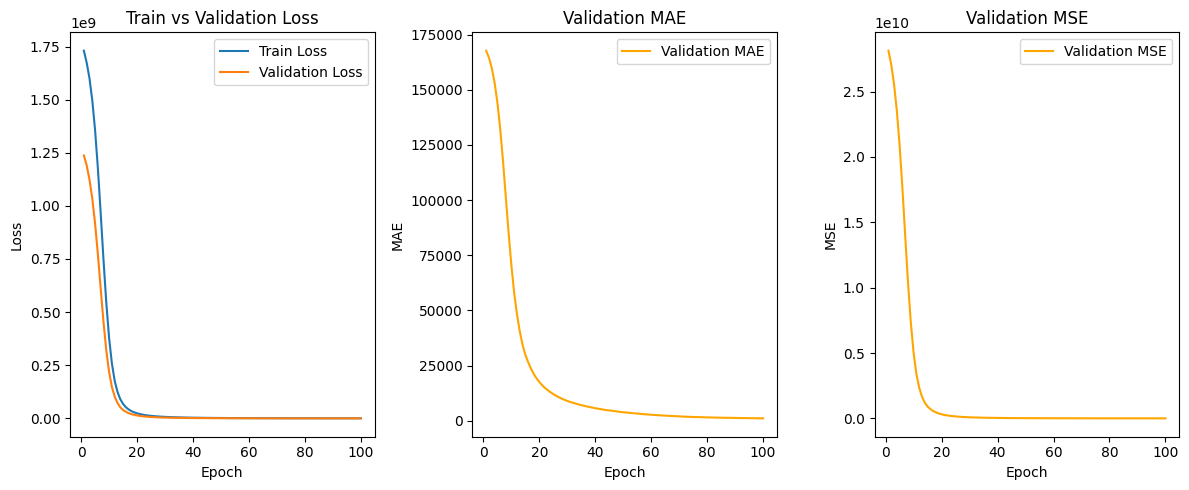

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses)+1)

plt.figure(figsize=(12, 5))

# Loss Grafiği
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()

# MAE Grafiği
plt.subplot(1, 3, 2)
plt.plot(epochs_range, val_maes, label="Validation MAE", color="orange")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Validation MAE")
plt.legend()

# MSE Grafiği
plt.subplot(1, 3, 3)
plt.plot(epochs_range, val_mses, label="Validation MSE", color="orange")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Validation MSE")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Kaydedilen modeli çalıştır
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AMRNet_ResNet18().to(device)
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

AMRNet_ResNet18(
  (initial): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (scale1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

Tahmini kişi sayısı: 41.75


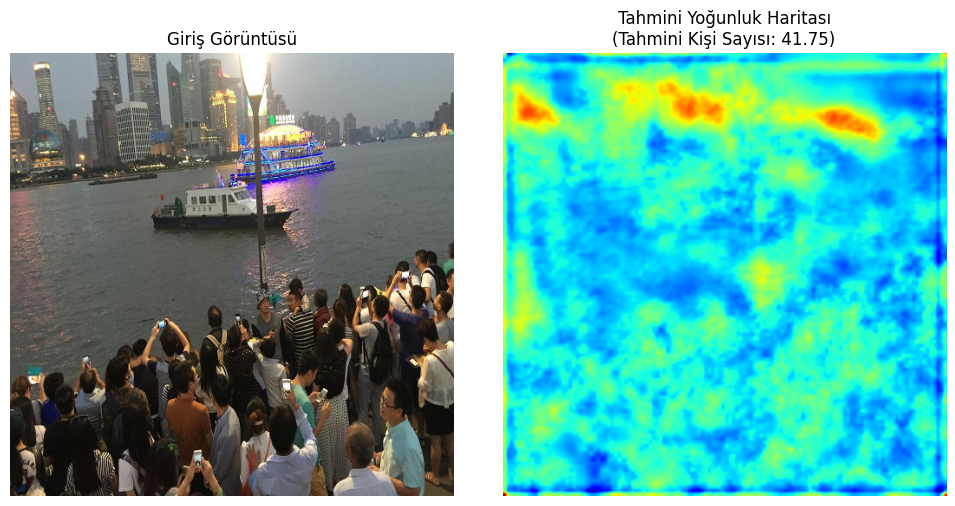

In [52]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

def test_single_image(model, image_path, device):
    # Görüntüyü oku
    image = cv2.imread(image_path)
    image = cv2.resize(image, (512, 512))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Görselleştirme için

    # Normalize et ve tensor formatına getir
    image_tensor = image.astype(np.float32) / 255.0
    image_tensor = np.transpose(image_tensor, (2, 0, 1))  # (C, H, W)
    image_tensor = torch.tensor(image_tensor).unsqueeze(0).to(device)  # (1, C, H, W)

    # Model ile tahmin et
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        output = F.interpolate(output, size=(512, 512), mode='bilinear', align_corners=False)
        density_map = output.squeeze().cpu().numpy()

    # Kişi sayısını yazdır
    count = density_map.sum()
    print(f"Tahmini kişi sayısı: {count:.2f}")

    # Görüntü ve yoğunluk haritasını göster
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title("Giriş Görüntüsü")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(density_map, cmap='jet')
    plt.title(f"Tahmini Yoğunluk Haritası\n(Tahmini Kişi Sayısı: {count:.2f})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


image_path = "/content/drive/MyDrive/dataset/test_data/images/WhatsApp Image 2025-03-28 at 01.28.41.jpeg"
test_single_image(model, image_path, device)

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test_model(model, dataloader, device, num_samples=5):
    model.eval()
    total_mae = 0
    total_mse = 0
    all_true = []
    all_pred = []
    count = 0

    with torch.no_grad():
        for images, densities in dataloader:
            images = images.to(device)
            densities = densities.to(device)

            outputs = model(images)

            if outputs.shape[-2:] != densities.shape[-2:]:
                outputs = F.interpolate(outputs, size=densities.shape[-2:], mode='bilinear', align_corners=False)

            pred_counts = outputs.sum(dim=[1, 2, 3])  # (B,)
            true_counts = densities.sum(dim=[1, 2, 3])  # (B,)

            total_mae += torch.abs(pred_counts - true_counts).sum().item()
            total_mse += ((pred_counts - true_counts) ** 2).sum().item()

            # Sınıflandırma için toleranslı etiketleme
            pred_labels = (torch.abs(pred_counts - true_counts) <= 500).long()
            true_labels = torch.ones_like(pred_labels)  # Gerçek sayımı doğru kabul ediyoruz

            all_true.extend(true_labels.cpu().numpy())
            all_pred.extend(pred_labels.cpu().numpy())

            count += images.size(0)
            if count >= num_samples:
                break  # 5 örnekle sınırla

    # Ortalama hataları hesapla
    mae = total_mae / min(count, num_samples)
    mse = total_mse / min(count, num_samples)

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")


# Test et
test_model(model, test_loader, device, num_samples=5)


Mean Absolute Error (MAE): 192.15
Mean Squared Error (MSE): 40884.02


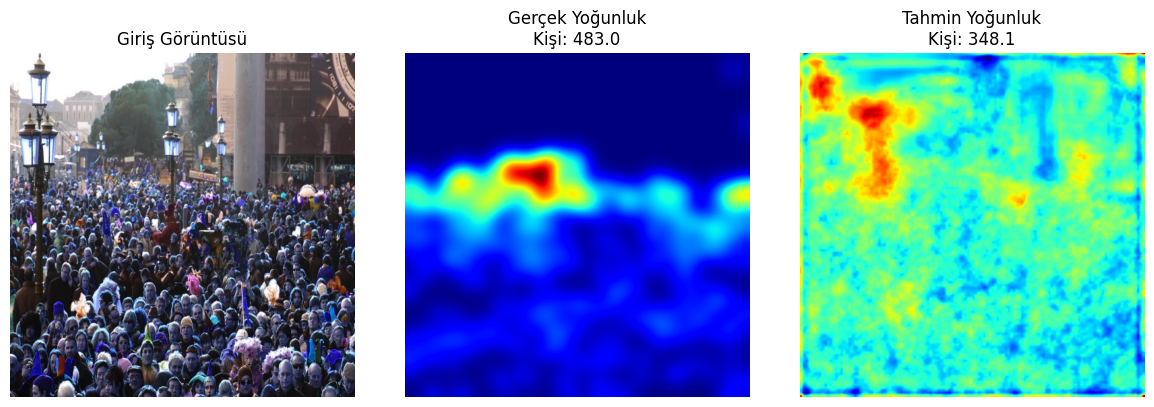

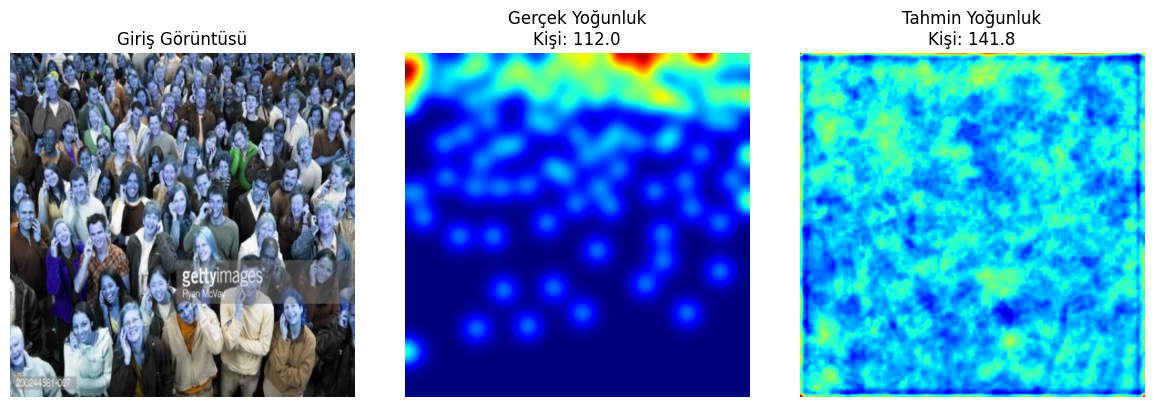

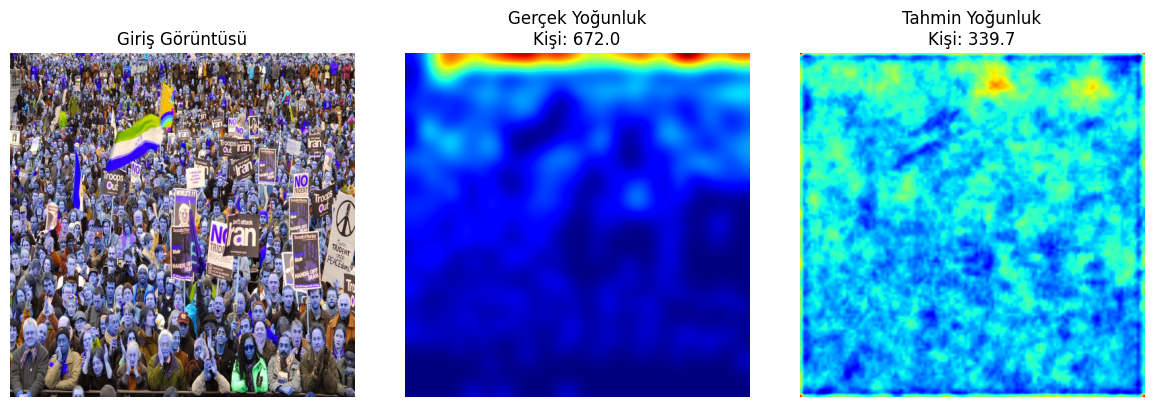

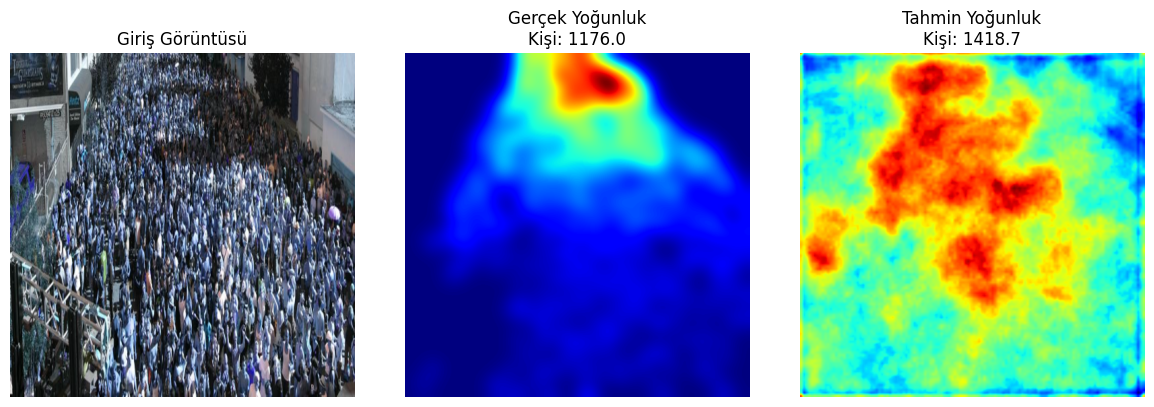

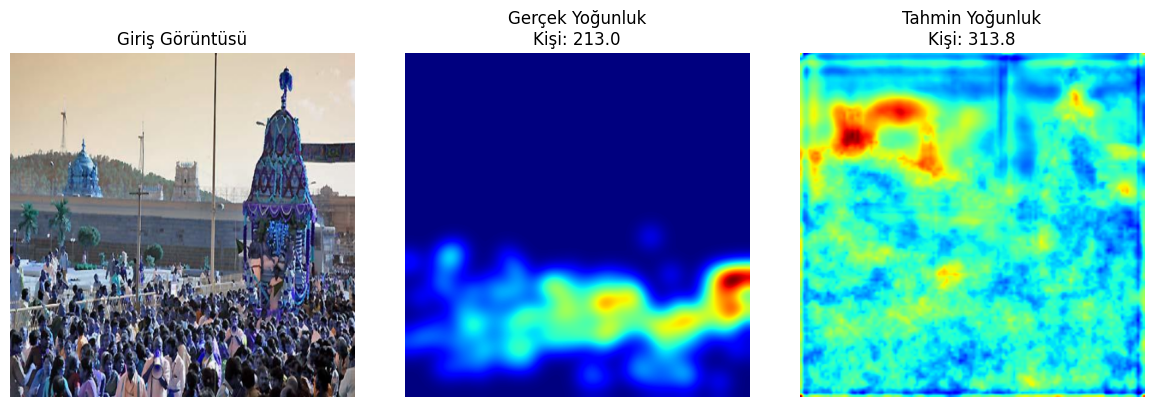

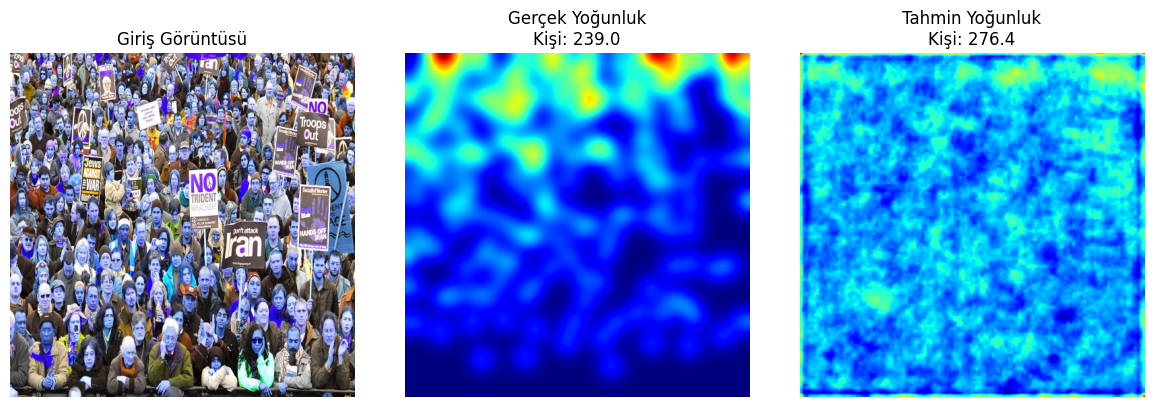

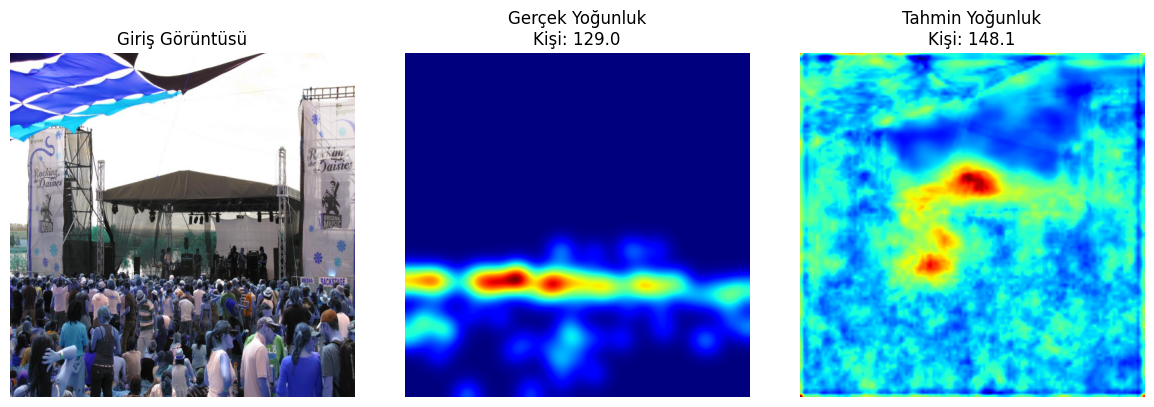

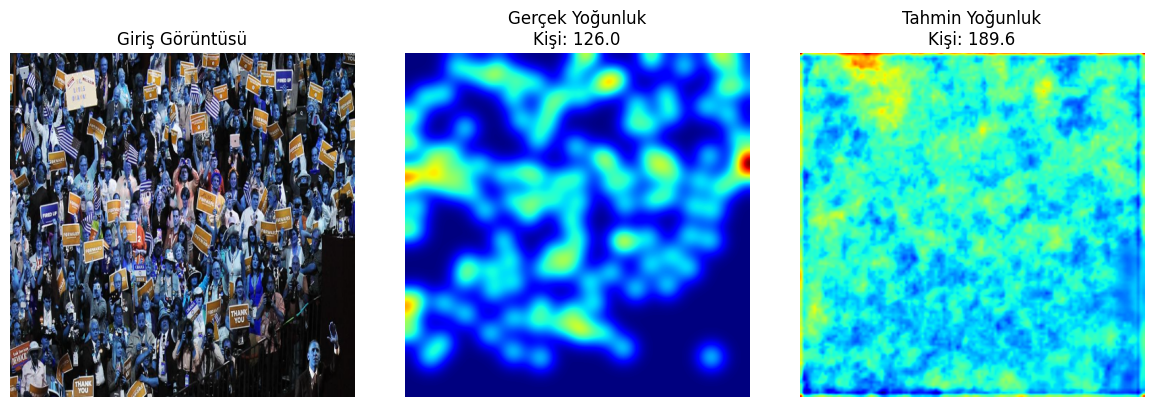

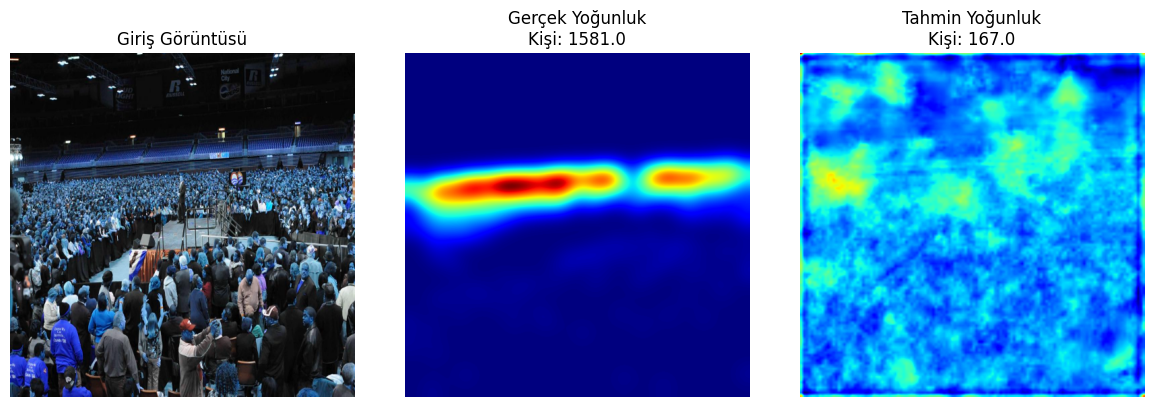

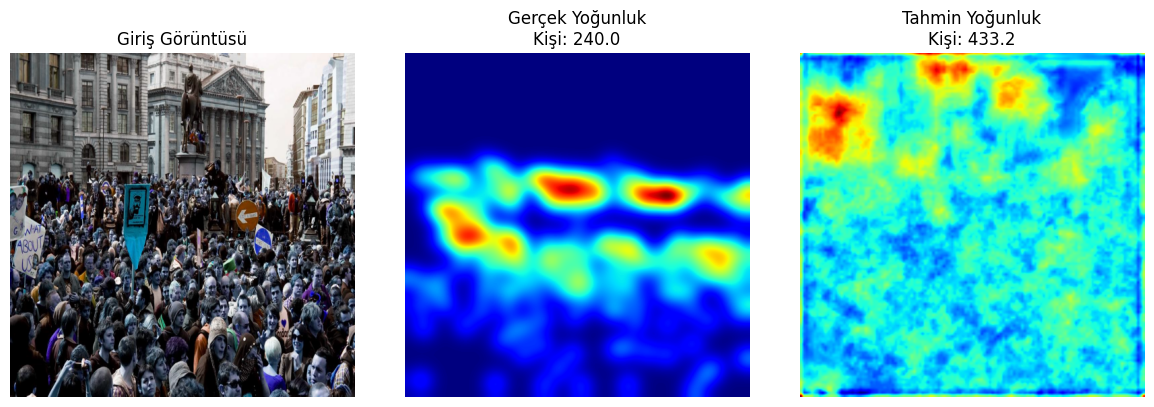

In [54]:
import torchvision.transforms.functional as TF

def visualize_predictions(model, dataloader, device, num_samples=5):
    model.eval()
    count = 0

    with torch.no_grad():
        for images, densities in dataloader:
            images = images.to(device)
            densities = densities.to(device)

            outputs = model(images)

            if outputs.shape[-2:] != densities.shape[-2:]:
                outputs = F.interpolate(outputs, size=densities.shape[-2:], mode='bilinear', align_corners=False)

            for i in range(images.size(0)):
                img = images[i].cpu()
                gt_density = densities[i].squeeze(0).cpu().numpy()
                pred_density = outputs[i].squeeze(0).cpu().numpy()

                # Toplam kişi sayısı tahmini
                gt_count = gt_density.sum()
                pred_count = pred_density.sum()

                # Görselleştir
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))

                axs[0].imshow(TF.to_pil_image(img))
                axs[0].set_title("Giriş Görüntüsü")
                axs[0].axis("off")

                axs[1].imshow(gt_density, cmap='jet')
                axs[1].set_title(f"Gerçek Yoğunluk\nKişi: {gt_count:.1f}")
                axs[1].axis("off")

                axs[2].imshow(pred_density, cmap='jet')
                axs[2].set_title(f"Tahmin Yoğunluk\nKişi: {pred_count:.1f}")
                axs[2].axis("off")

                plt.tight_layout()
                plt.show()

                count += 1
                if count >= num_samples:
                    return  # Belirtilen kadar örnek göster


# Model tahminlerini görselleştir
visualize_predictions(model, test_loader, device, num_samples=10)